In [2]:
import pickle
from forecast import Forecaster

with open('..\\deep learning\\trained_forecaster.pkl', 'rb') as f:
    forecaster = pickle.load(f)

In [3]:
import pandas as pd

def fetch_observations(filepath, from_date, to_date):
    data = pd.read_csv(filepath)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index(['Date', 'Hour'], inplace=True)
    data = data.loc[(from_date, 6):(to_date, 24)]
    data.reset_index(inplace=True)
    return data

In [ ]:
import matplotlib.pyplot as plt

date = '2024-12-21'
days_forward = 5
county = 'Palo Pinto'
variable = 'Temperature'

d1 = pd.to_datetime(date)
d2 = d1 - pd.Timedelta(days=1)
d3 = d1 - pd.Timedelta(days=3)
d4 = d1 + pd.Timedelta(days=days_forward-1)

forecaster.generate(date, days_forward)

historical_observations = fetch_observations('..\\preprocessing\\county_variables.csv', str(d3.date()), str(d2.date()))
actual_observations = fetch_observations('..\\preprocessing\\county_variables.csv', str(d1.date()), str(d4.date()))
predicted_observations = fetch_observations('forecast.csv', str(d1.date()), str(d4.date()))

actual_df = pd.concat((historical_observations, actual_observations), ignore_index=True)
predicted_df = pd.concat((historical_observations, predicted_observations), ignore_index=True)

actual_df = actual_df.groupby('Date').mean()
predicted_df = predicted_df.groupby('Date').mean()

column_name = f'{county}_{variable.lower()}'
#print(column_name)

variable_columns = [x for x in actual_df.columns if variable.lower() in x]
#print(variable_columns)
diff_df = actual_df[variable_columns] - predicted_df[variable_columns]
diffs = diff_df.mean(axis=1)

#print(diffs_df)

actual_variable = actual_df[column_name].values
predicted_variable = predicted_df[column_name].values

plt.plot(range(len(diffs)), diffs.values)#, #actual_variable, predicted_variable)
plt.plot(range(len(actual_variable)), actual_variable, predicted_variable)
plt.show()

In [ ]:
actual_df

In [ ]:
predicted_df

In [124]:
def get_forecast_error(forecaster, date, days_forward):
    d1 = pd.to_datetime(date)
    d4 = d1 + pd.Timedelta(days=days_forward-1)

    forecaster.generate(date, days_forward)
    
    actual_observations = fetch_observations('..\\preprocessing\\county_variables.csv', str(d1.date()), str(d4.date()))
    predicted_observations = fetch_observations('forecast.csv', str(d1.date()), str(d4.date()))

    actual_df = actual_observations.groupby('Date').mean()
    predicted_df = predicted_observations.groupby('Date').mean()

    temp_columns = [x for x in actual_df.columns if 'temp' in x]
    precip_columns = [x for x in actual_df.columns if 'precip' in x]
    snow_columns = [x for x in actual_df.columns if 'snow' in x]
    wind_columns = [x for x in actual_df.columns if 'wind' in x]

    temp_means = actual_df[temp_columns].mean(axis=1)
    precip_means = actual_df[precip_columns].mean(axis=1)
    snow_means = actual_df[snow_columns].mean(axis=1)
    wind_means = actual_df[wind_columns].mean(axis=1)

    temp_diffs = actual_df[temp_columns].subtract(predicted_df[temp_columns]).mean(axis=1)
    precip_diffs = actual_df[precip_columns].subtract(predicted_df[precip_columns]).mean(axis=1)
    snow_diffs = actual_df[snow_columns].subtract(predicted_df[snow_columns]).mean(axis=1)
    wind_diffs = actual_df[wind_columns].subtract(predicted_df[wind_columns]).mean(axis=1)
    
    temp_abs_diffs = actual_df[temp_columns].subtract(predicted_df[temp_columns]).abs().mean(axis=1)
    precip_abs_diffs = actual_df[precip_columns].subtract(predicted_df[precip_columns]).abs().mean(axis=1)
    snow_abs_diffs = actual_df[snow_columns].subtract(predicted_df[snow_columns]).abs().mean(axis=1)
    wind_abs_diffs = actual_df[wind_columns].subtract(predicted_df[wind_columns]).abs().mean(axis=1)

    day_errors = {}
    for i in range(days_forward):
        day_errors[i+1] = {
            'Temperature': temp_diffs.iloc[i],
            'Precipitation': precip_diffs.iloc[i],
            'Snow': snow_diffs.iloc[i],
            'Wind Speed': wind_diffs.iloc[i]
        }
    day_abs_errors = {}
    for i in range(days_forward):
        day_abs_errors[i+1] = {
            'Temperature': temp_abs_diffs.iloc[i],
            'Precipitation': precip_abs_diffs.iloc[i],
            'Snow': snow_abs_diffs.iloc[i],
            'Wind Speed': wind_abs_diffs.iloc[i]
        }
    day_pct_errors = {}
    for i in range(days_forward):
        day_pct_errors[i+1] = {
            'Temperature': temp_diffs.iloc[i] / temp_means.iloc[i],
            'Precipitation': precip_diffs.iloc[i] / (precip_means.iloc[i] + 0.001),
            'Snow': snow_diffs.iloc[i] / (snow_means.iloc[i] + 0.001),
            'Wind Speed': wind_diffs.iloc[i] / wind_means.iloc[i]
        }
    day_abs_pct_errors = {}
    for i in range(days_forward):
        day_abs_pct_errors[i+1] = {
            'Temperature': temp_abs_diffs.iloc[i] / temp_means.iloc[i],
            'Precipitation': precip_abs_diffs.iloc[i] / (precip_means.iloc[i] + 0.001),
            'Snow': snow_abs_diffs.iloc[i] / (snow_means.iloc[i] + 0.001),
            'Wind Speed': wind_abs_diffs.iloc[i] / wind_means.iloc[i]
        }

    return day_errors, day_abs_errors, day_pct_errors, day_abs_pct_errors


In [128]:
import matplotlib.pyplot as plt

errors = []
abs_errors = []
pct_errors = []
abs_pct_errors = []
start_date = pd.to_datetime('2020-01-01')

for i in range(365 * 3):
    if i % 50 == 0:
        print(i)
    current_date = str((start_date + pd.Timedelta(days=i)).date())
    errors_, abs_errors_, pct_errors_, abs_pct_errors_ = get_forecast_error(forecaster, current_date, 7)
    errors.append(errors_)
    abs_errors.append(abs_errors_)
    pct_errors.append(pct_errors_)
    abs_pct_errors.append(abs_pct_errors_)

# temp_errors = []
# for e in errors:
#     temp_errors.append(errors[e]['Temperature'])

# plt.plot(range(len(temp_errors)), temp_errors)
# plt.show()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050


In [52]:
errors_2024[0][1]['Temperature']

np.float64(22.70568965517241)

0.22297665693911303
0.2229766569390945


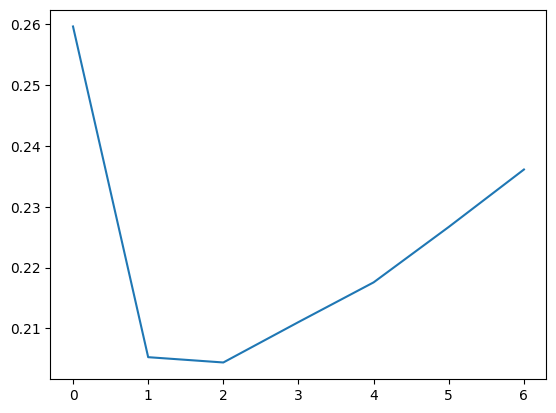

In [136]:
variable = 'Temperature'
errors_to_use = abs_pct_errors

temp_error_avgs = [0, 0, 0, 0, 0, 0, 0]
counter = 0

total_error = 0
total_counter = 0

for i in range(len(errors_to_use)):
    for j in range(7):
        if pd.isna(errors_to_use[i][j+1][variable]):
            continue
        else:
            total_counter += 1
            counter += (1/7)
        error = errors_to_use[i][j+1][variable]
        total_error += error
        temp_error_avgs[j] += (error)
    #print(temp_error_avgs)

for i in range(7):
    temp_error_avgs[i] /= counter

print(sum(temp_error_avgs)/7)
print(total_error/total_counter)

plt.plot(range(7), temp_error_avgs)
plt.show()